| ![EEW logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/eew.jpg?raw=true) | ![EDGI logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/edgi.png?raw=true) |
|---|---|

#### This notebook is licensed under GPL 3.0. Please visit our Github repo for more information: https://github.com/edgi-govdata-archiving/ECHO-COVID19
#### The notebook was collaboratively authored by EDGI following our authorship protocol: https://docs.google.com/document/d/1CtDN5ZZ4Zv70fHiBTmWkDJ9mswEipX6eCYrwicP66Xw/
#### For more information about this project, visit https://www.environmentalenforcementwatch.org/

# Tracking EPA's COVID-19 non-enforcement policy
In late March 2020, EPA released a memo announcing that it would not penalize regulated industries that fail to meet their monitoring and reporting requirements due to COVID-19. Specifically EPA has said that it:

> "is not seeking penalties for noncompliance only in circumstances that involve routine monitoring and reporting requirements, if, on a case-by-case basis, EPA agrees that such noncompliance was caused by the COVID-19 pandemic."

This may have a number of public and environmental health impacts if facilities respond by increasing their emissions and discharges. Our response to this memo states that the EPA’s COVID-19 leniency is [a “free pass to pollute.](https://envirodatagov.org/epas-covid-19-leniency-is-a-free-pass-to-pollute/)”

Using this notebook, you can track how facilities' releases—as well as monitoring and reporting—of air and water hazards has changed in your state over the past few months, compared to previous years. 

There are three scenarios we may see playing out:

_Monitoring and reporting violations_
- 1. **Facilities that do *not* report** (we can track this)....**but do still meet their permit limits** (yet we can't know this specifically, precisely because they didn't report)
- 2. **Facilities that do *not* report** (we can track this)....**and actually exceed their limits** (yet we can't know this specifically, precisely because they didn't report)

_Environmental violations_
- 3. **Facilities that do meet their reporting obligations** BUT they **report having exceeded their permitted limits**. In this case, we can also track whether EPA takes any enforcement action.

We may also see facilities that both meet their reporting obligations and do not exceed their permitted limits. These facilities may still pose a risk to community and environmental health but are not the focus of this investigation. Please see…

This investigation relies upon data from the EPA’s Enforcement & Compliance History Online (ECHO), the primary open data portal supplied by the EPA, and a major basis for EPA’s decisions around enforcement. Please see EPA’s “About the Data” page for known limitations on the data’s quality and completeness. Link to data source (https://echo.epa.gov/tools/data-downloads#downloads) and limitations (https://echo.epa.gov/resources/echo-data/about-the-data)

Organization of this notebook:
 - Air emissions
 - Water discharges from major sources 
 - Water quality monitoring and reporting violations
---

## How to Run this Notebook
* If you click on a gray **code** cell, a little “play button” arrow appears on the left. If you click the play button, it will run the code in that cell (“**running** a cell”). The button will animate. When the animation stops, the cell has finished running.
![Where to click to run the cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/pressplay.JPG?raw=true)
* You may get a warning that the notebook was not authored by Google. We know, we authored them! It’s okay. Click “Run Anyway” to continue. 
![Error Message](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/warning-message.JPG?raw=true)
* Run all of the cells in a Notebook to make a complete report. Please feel free to look at and **learn about each result as you create it**!

---

## Setup
Here we load some helper code to get us going.

In [1]:
!git clone https://github.com/edgi-govdata-archiving/ECHO_modules.git
!git clone https://github.com/edgi-govdata-archiving/ECHO-COVID19.git
    

# Import code libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import csv
import datetime
import folium
import ipywidgets as widgets

Cloning into 'ECHO_modules'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 27 (delta 7), reused 16 (delta 4), pack-reused 0
Unpacking objects: 100% (27/27), 7.45 KiB | 152.00 KiB/s, done.
Cloning into 'ECHO-COVID19'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 136 (delta 77), reused 64 (delta 28), pack-reused 0
Receiving objects: 100% (136/136), 15.28 MiB | 6.27 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [2]:
%run ECHO-COVID19/utilities.py
%run ECHO_modules/DataSet.py

ERROR:root:File `'ECHO-COVID19/utilities.py'` not found.


## Pick a month
We'll look at trends for the month you select across the past few decades of pollution trends

In [25]:
# Make a dropdown menu showing each month
months_list=["January","February","March","April","May","June","July","August","September","October","November","December"]
w=widgets.Dropdown(
    options=months_list,
    value = "March",
    description='Month:'
)
# Display the widget so you can select the month
display(w)

Dropdown(description='Month:', index=2, options=('January', 'February', 'March', 'April', 'May', 'June', 'July…

In [26]:
# Assign the month you chose to the variable “mnth”
mnth_name=w.value
mnth = "{0:0=2d}".format(months_list.index(mnth_name) + 1) # Converts month name to 2-digit string number

## Are facilities monitoring their air emissions?
"Stack tests" involve measuring the volume of pollutants coming out of the facility's "smokestack".

The following cell will grab EPA data on facility stack tests for every one of the selected months on record (up to 50 years ago). Some pollutant releases may be seasonal, so by looking only at the selected month, we can account for this variation and ensure an apples-to-apples comparison.

In addition, we will only look at data post-2000, as EPA notes that its data systems prior to that date are incomplete and hence "unknown."

In [10]:
# Use SQL to search for and select the data about air stack tests for the month you chose over the past 20 years
sql = "select * from `ICIS-AIR_STACK_TESTS` where ACTUAL_END_DATE like '"+mnth+"/%'"
stack_data = get_data( sql, 'pgm_sys_id' )

# This is your data!
stack_data

,ACTIVITY_ID,COMP_MONITOR_TYPE_CODE,COMP_MONITOR_TYPE_DESC,STATE_EPA_FLAG,ACTUAL_END_DATE,POLLUTANT_CODES,POLLUTANT_DESCS,AIR_STACK_TEST_STATUS_CODE,AIR_STACK_TEST_STATUS_DESC
pgm_sys_id,,,,,,,,,
CT0000000900300005,3400331189,CST,Stack Test,S,04/26/2007,Mercury,NaN,PSS,Pass
CT0000000900300005,3400331252,CST,Stack Test,S,04/28/2009,TOTAL PARTICULATE MATTER,NaN,PSS,Pass
CT0000000900300005,3400331300,CST,Stack Test,S,04/28/2009,NITROGEN OXIDES NO2,NaN,PSS,Pass
CT0000000900300005,3400331331,CST,Stack Test,S,04/28/2010,Mercury,NaN,PSS,Pass
CT0000000900300005,3400331352,CST,Stack Test,S,04/28/2011,Mercury,NaN,PSS,Pass
...,...,...,...,...,...,...,...,...,...
080000004904700106,3600949251,CST,Stack Test,E,04/28/2015,NaN,NaN,PSS,Pass
PA000238561,3601939171,CST,Stack Test,S,04/26/2000,NaN,NaN,PSS,Pass
IA0000001901700030,3600399426,CST,Stack Test,S,04/29/2015,NaN,NaN,PSS,Pass


#### Chart stack tests

The height of each bar will indicate how many tests there were, while the orange line will show us the average number of these for all previous Aprils and the pink line indicates the average for the past three years.

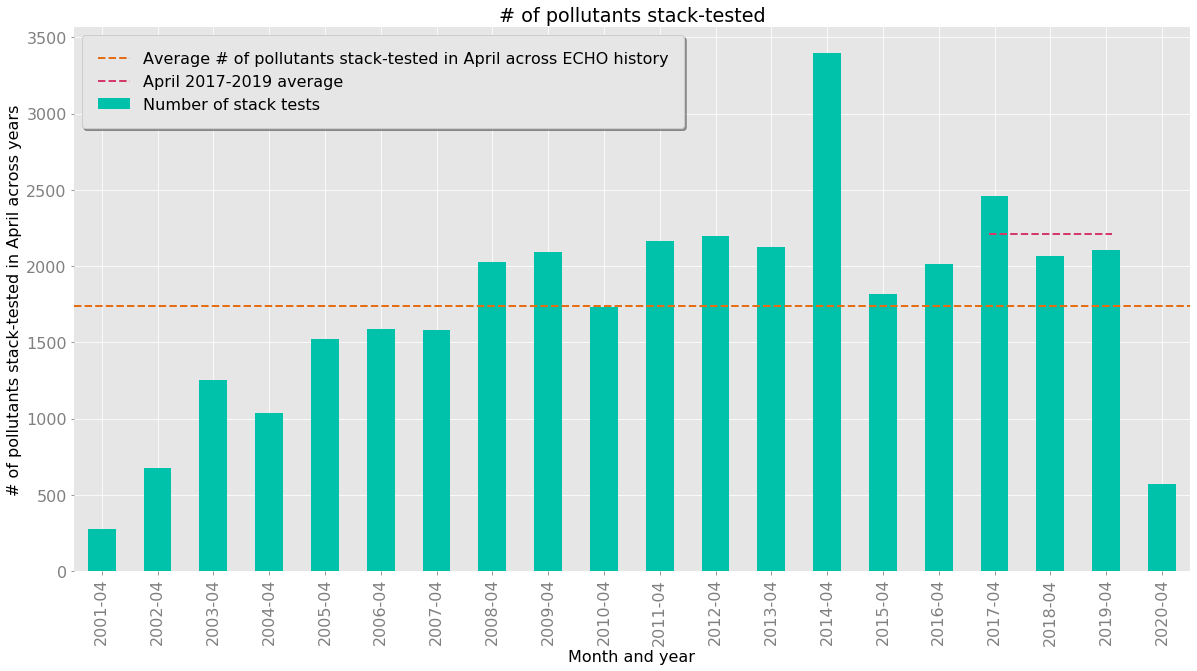

In [31]:
charter(stack_data, 'ACTUAL_END_DATE', "%m/%d/%Y", mnth, mnth_name, 'STATE_EPA_FLAG', 
        "Number of stack tests", "air_monitoring.csv", "# of pollutants stack-tested", 
        "count")

### Which facilities should have been conducting stack tests? 
Of those facilities that have reported stack tests in the past 20 years, we will look at the worst - the 25% that reported the fewest stack tests.

In [32]:
# Use SQL to search for and select the data about air stack tests over the past 20 years
sql = "select * from `ICIS-AIR_STACK_TESTS` where ACTUAL_END_DATE >= '01/01/2001'"

# Download the data from that URL
stack_data = get_data( sql, 'pgm_sys_id' )

stack_data["ACTUAL_END_DATE"]= pd.to_datetime(stack_data["ACTUAL_END_DATE"], format="%m/%d/%Y", errors = 'coerce') 

# This is your data!
stack_data

,ACTIVITY_ID,COMP_MONITOR_TYPE_CODE,COMP_MONITOR_TYPE_DESC,STATE_EPA_FLAG,ACTUAL_END_DATE,POLLUTANT_CODES,POLLUTANT_DESCS,AIR_STACK_TEST_STATUS_CODE,AIR_STACK_TEST_STATUS_DESC
pgm_sys_id,,,,,,,,,
NH0000003301700003,123027,CST,Stack Test,E,2004-06-24,HAPS [HAZARDOUS AIR POLLUTANTS/AIR TOXICS],NaN,NaN,NaN
RI0000004400709014,600024996,CST,Stack Test,E,2006-11-20,Volatile organic compounds,NaN,NaN,NaN
RI0000004400900010,600024945,CST,Stack Test,E,2006-11-17,Volatile organic compounds,NaN,NaN,NaN
CT0000000900900001,600035898,CST,Stack Test,E,2007-01-18,Volatile organic compounds,NaN,NaN,NaN
ME0000002301900016,600066226,CST,Stack Test,E,2007-08-07,Volatile organic compounds,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
080000003805300125,3600243173,CST,Stack Test,E,2015-07-11,NaN,NaN,PSS,Pass
NC0000003700700071,3401400532,CST,Stack Test,S,2013-10-24,NaN,NaN,PSS,Pass
TX0000004805700003,3402075218,CST,Stack Test,S,2008-02-02,NaN,NaN,PSS,Pass


In [33]:
count = stack_data.groupby([stack_data.index])[["ACTUAL_END_DATE"]].agg("count") / 19 # Per year inspection rate.
quartile = count.describe().loc["25%", "ACTUAL_END_DATE"] # Calculate quartile in terms of inspection rate.
worst = count[(count["ACTUAL_END_DATE"] <= quartile)] # The 25% of facilities inspected the least (likely once in 19 years)
print("The 25% of facilities that reported stack tests the least between 2001 and 2020 only reported "+str(quartile*19)+" time during that period")

The 25% of facilities that reported stack tests the least between 2001 and 2020 only reported 1.0 time during that period


#### Let's map where these non-stack testers are.

In [34]:
# Pull out Ids to match ECHO_EXPORTER
ids = worst.index.unique()

if (len(worst.index)>0):
    # Get facility information from ECHO
    sql = "select FAC_NAME, AIR_IDS, FAC_LAT, FAC_LONG, FAC_PERCENT_MINORITY, CAA_QTRS_WITH_NC, DFR_URL" + \
        " from ECHO_EXPORTER where AIR_FLAG = 'Y' "
    air_echo_data = get_data( sql )
    # Filter ECHO EXPORTER data to rows containing pgm_sys_ids from latest  
    idxs=list()
    for index,value in air_echo_data["AIR_IDS"].items():
        for i in value.split():
            if i in ids:
                idxs.append(index)
    air_echo_data = air_echo_data.iloc[idxs,:]
    air_echo_data.set_index( 'AIR_IDS', inplace=True ) 
                               
    # Merge ECHO and CAA data
    worst = worst.join(air_echo_data)
    
else:
    print("A problem occurred...")

In [35]:
missing = worst[(np.isnan(worst["FAC_LAT"])) | (np.isnan(worst["FAC_LONG"]))]
count = missing.index.unique()
print("There are "+str(len(count))+" facilities we can't map because they have incomplete data")
# Filter to remove NaNs - missing data!
worst = worst[~(np.isnan(worst["FAC_LAT"])) | ~(np.isnan(worst["FAC_LONG"]))]
print("There are "+str(len(worst))+"facilities mapped below.")
map_of_facilities = mapper(worst)
map_of_facilities

There are 622 facilities we can't map because they have incomplete data
There are 6495facilities mapped below.


NameError: name 'folium' is not defined

## Are facilities being inspected?
Stack tests may not be happening, but regulators could go in and inspect facilities.
#### Get the data

In [ ]:
sql = "select * from `ICIS-AIR_FCES_PCES` where ACTUAL_END_DATE like '"+mnth+"-%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

eval_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
eval_data.set_index("PGM_SYS_ID", inplace=True)
eval_data

#### Chart inspections

In [ ]:
charter(eval_data, 'ACTUAL_END_DATE', "%m-%d-%Y", 'ACTIVITY_TYPE_DESC', "Number of inspections", 
        "caa_inspections.csv", "# of inspections", "count")

## What have facilities reported releasing into the air?
Air pollution is associated with greater virulence of COVID-19. What are facilities releasing into the air in spite of this greater risk to human life?

We'll start by looking at those facilities that were found to be in violation for their emissions.

In [ ]:
sql = "select * from `ICIS-AIR_VIOLATION_HISTORY` where HPV_DAYZERO_DATE like '"+mnth+"-%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

air_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
air_data.set_index("pgm_sys_id", inplace=True)
# Remove "FACIL" violations, which are paperwork violations according to: https://19january2017snapshot.epa.gov/sites/production/files/2013-10/documents/frvmemo.pdf
air_data = air_data.loc[(air_data["POLLUTANT_DESCS"]!="FACIL")]
air_data

#### Chart emissions violations
The height of each bar indicates how many emissions violations there have been. The orange line shows the average number of emissions violations for all previous years, and the pink line indicates the average for the past three years.

In [ ]:
charter(air_data, 'HPV_DAYZERO_DATE', "%m-%d-%Y", 'ENF_RESPONSE_POLICY_CODE', 
        "Number of violations", "air_violations_total.csv", "# of Clean Air Act violations", "count")

facilities = air_data.reset_index()
facilities = facilities.groupby(['HPV_DAYZERO_DATE']).agg({"pgm_sys_id": "nunique"})
facilities = facilities.reset_index()
charter(facilities, 'HPV_DAYZERO_DATE', "%m/%d/%Y", 'pgm_sys_id', "Number of facilities exceeding", 
        "caa_violations_facilities.csv", "# of facilities exceeding", "sum")

#### Let's focus on the selected month and this year (2020) and break it down by type of pollutant whose levels were exceeded.

In [ ]:
mnth1 = "0" + str(int(mnth) + 1)
now = air_data[(air_data["HPV_DAYZERO_DATE"] >= '2020-'+mnth+'-01') & (air_data["HPV_DAYZERO_DATE"] < '2020-'+mnth1+'-01')]

pollutants = now.groupby(['POLLUTANT_DESCS'])[['ACTIVITY_ID']].count()
pollutants = pollutants.rename(columns={'ACTIVITY_ID': "Violations"})
pollutants = pollutants.sort_values(by='Violations', ascending=False)
fig = plt.figure(1, figsize=(20,20))
ax = fig.add_subplot(111)
wedges, labels, autopct = ax.pie(pollutants["Violations"], labels = pollutants.index, autopct='%1.1f%%', radius = 10);#, textprops={'fontsize': 72});
for pos,lab in enumerate(labels):
    if pos < 10:
        lab.set_fontsize(96)

#### Where are these facilities that exceeded their permits?
Even if, on the whole, there are fewer exceedances, the places that are emitting more pollutants are important to track. Their neighbors are suffering more.

In [ ]:
mnth1 = "0" + str(int(mnth) + 1)
latest = air_data[(air_data["HPV_DAYZERO_DATE"] >= '2020-'+mnth+'-01') & (air_data["HPV_DAYZERO_DATE"] < '2020-'+mnth1+'-01')]

# Pull out Ids to match ECHO_EXPORTER
ids = latest.index.unique()

if (len(latest.index)>0):
    # Get facility information from ECHO
    sql = "select FAC_NAME, AIR_IDS, FAC_LAT, FAC_LONG, FAC_PERCENT_MINORITY, CAA_QTRS_WITH_NC, DFR_URL" + \
        " from ECHO_EXPORTER where AIR_FLAG = 'Y' "
    url='http://apps.tlt.stonybrook.edu/echoepa/?query='
    data_location=url+urllib.parse.quote(sql)
    air_echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
    # Filter ECHO EXPORTER data to rows containing pgm_sys_ids from latest  
    idxs=list()
    for index,value in air_echo_data["AIR_IDS"].items():
        for i in value.split():
            if i in ids:
                idxs.append(index)
    air_echo_data = air_echo_data.iloc[idxs,:]
    air_echo_data.set_index( 'AIR_IDS', inplace=True ) 
                               
    # Merge ECHO and CAA data
    latest = latest.join(air_echo_data)
    
else:
    print("Actually, there were no permit exceedences for %s" %(mnth_name))

#### Make the map!
The map shows us all the facilities that report emitting more than their permitted levels in the selected month.

In [ ]:
missing = latest[(np.isnan(latest["FAC_LAT"])) | (np.isnan(latest["FAC_LONG"]))]
count = missing.index.unique()
print("There are "+str(len(count))+" facilities we can't map because they have incomplete data")
# Filter to remove NaNs - missing data!
latest = latest[~(np.isnan(latest["FAC_LAT"])) | ~(np.isnan(latest["FAC_LONG"]))]
print("There are "+str(len(latest))+"facilities mapped below.")
map_of_facilities = mapper(latest)
map_of_facilities

#### Of these known violators, how many quarters have they spent in non-compliance recently?
These may be habitually "bad actors" who should not be let off the hook (but likely will be given EPA's non-enforcement policy)

In [ ]:
mnth1 = "0" + str(int(mnth) + 1)
latest = air_data[(air_data["HPV_DAYZERO_DATE"] >= '2020-'+mnth+'-01') & (air_data["HPV_DAYZERO_DATE"] < '2020-'+mnth1+'-01')]

# Pull out Ids to match ECHO_EXPORTER
ids = latest.index.unique()

latest = latest.join(air_echo_data)

bad_actors = latest.groupby(latest.index)[["CAA_QTRS_WITH_NC"]].mean()
bad_actors = bad_actors[~(np.isnan(bad_actors["CAA_QTRS_WITH_NC"]))]
bad_actors["CAA_QTRS_WITH_NC"] = (bad_actors["CAA_QTRS_WITH_NC"]/12)*100
bad_actors["CAA_QTRS_WITH_NC"].median()
plt.hist(bad_actors["CAA_QTRS_WITH_NC"], density=False, bins=10);
plt.ylabel('Number of facilities')
plt.xlabel('Percent of the last 12 quarters non-compliant with the Clean Air Act');

---

## What are facilities releasing into the water?

*NOTE*: Because there are so many facilities that discharge into waters of the US, there's a lot of data! The following cell may take a little while to run.

In [ ]:
# Find facilities with pollutant exceedences
sql = "select NPDES_ID, EXCEEDENCE_PCT, MONITORING_PERIOD_END_DATE, PARAMETER_DESC" + \
    " from NPDES_EFF_VIOLATIONS where EXCEEDENCE_PCT > 0 and MONITORING_PERIOD_END_DATE like '"+mnth+"/%'"

url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

dis_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
dis_data.set_index("NPDES_ID", inplace=True)
exceeds = dis_data 
exceeds

#### Chart Clean Water Act exceedances
Are facilities exceeding their permits more this month in 2020 than previous years? Like with air emissions and monitoring, we need to compare month-month (e.g. March 2019 to March 2020) because there is a seasonality to many discharges.

The height of each bar will indicate how many pollution permits have been exceeded, while the orange line will show us the average number of these for all previous years and the pink line indicates the average for the past three years.

In the second chart, the height of each bar will indicate how many *facilities* have exceeded their permits.

In [ ]:
charter(exceeds, 'MONITORING_PERIOD_END_DATE', "%m/%d/%Y", 'EXCEEDENCE_PCT', "Number of pollution permits exceeded", 
        "cwa_violations_total.csv", "# of permit exceedances", "count")

facilities = exceeds.reset_index()
facilities = facilities.groupby(['MONITORING_PERIOD_END_DATE']).agg({"NPDES_ID": "nunique"})
facilities = facilities.reset_index()
charter(facilities, 'MONITORING_PERIOD_END_DATE', "%m/%d/%Y", 'NPDES_ID', "Number of facilities exceeding", 
        "cwa_violations_facilities.csv", "# of facilities exceeding", "sum")

#### Let's look at the selected month and this year (2020) and break it down by type of pollutant.
That is, we're going to zoom in on the rightmost bar in the bar charts above.

In [ ]:
mnth1 = "0" + str(int(mnth) + 1)
now = exceeds[(exceeds['MONITORING_PERIOD_END_DATE'] >= '2020-'+mnth+'-01') & (exceeds['MONITORING_PERIOD_END_DATE'] < '2020-'+mnth1+'-01')] 

pollutants = now.groupby(['PARAMETER_DESC'])[['MONITORING_PERIOD_END_DATE']].count()
pollutants = pollutants.rename(columns={'MONITORING_PERIOD_END_DATE': "Violations"})
pollutants = pollutants.sort_values(by='Violations', ascending=False)
fig = plt.figure(1, figsize=(20,20))
ax = fig.add_subplot(111)
wedges, labels, autopct = ax.pie(pollutants["Violations"], labels = pollutants.index, autopct='%1.1f%%', radius = 10);#, textprops={'fontsize': 72});
for pos,lab in enumerate(labels):
    if pos < 10:
        lab.set_fontsize(96)

#### Where are the facilities that are currently exceeding their Clean Water Act emissions?

In [ ]:
mnth1 = "0" + str(int(mnth) + 1)
latest = exceeds[(exceeds['MONITORING_PERIOD_END_DATE'] >= '2020-'+mnth+'-01') & (exceeds['MONITORING_PERIOD_END_DATE'] < '2020-'+mnth1+'-01')] 

# Pull out Ids to match ECHO_EXPORTER
ids = latest.index.unique()

if (len(latest.index)>0):
    # Get facility information from ECHO
    sql = "select FAC_NAME, NPDES_IDS, FAC_LAT, FAC_LONG, FAC_PERCENT_MINORITY, CWA_QTRS_WITH_NC, DFR_URL" + \
        " from ECHO_EXPORTER where NPDES_FLAG = 'Y' "
    url='http://apps.tlt.stonybrook.edu/echoepa/?query='
    data_location=url+urllib.parse.quote(sql)
    water_echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
    # Filter ECHO EXPORTER data to rows containing pgm_sys_ids from latest  
    idxs=list()
    for index,value in water_echo_data["NPDES_IDS"].items():
        for i in value.split():
            if i in ids:
                idxs.append(index)
    water_echo_data = water_echo_data.iloc[idxs,:]
    water_echo_data.set_index( 'NPDES_IDS', inplace=True )
    
    # Merge ECHO and NPDES data
    latest = latest.join(water_echo_data)
    print(latest)
    
else:
    print("Actually, there were no reporting violations for %s" %(mnth_name))    

In [ ]:
missing = latest[(np.isnan(latest["FAC_LAT"])) | (np.isnan(latest["FAC_LONG"]))]
count = missing.index.unique()
print("There are "+str(len(count))+" facilities we can't map because they have incomplete data")
latest = latest[~(np.isnan(latest["FAC_LAT"])) | ~(np.isnan(latest["FAC_LONG"]))] # Filter to remove NaNs - missing data!
print("There are "+str(len(latest))+"facilities mapped below.")
map_of_facilities = mapper(latest)
map_of_facilities

#### Of these known violators, how many quarters have they spent in non-compliance recently?
These may be habitually "bad actors" who should not be let off the hook (but likely will be given EPA's non-enforcement policy)

In [ ]:
mnth1 = "0" + str(int(mnth) + 1)
latest = exceeds[(exceeds['MONITORING_PERIOD_END_DATE'] >= '2020-'+mnth+'-01') & (exceeds['MONITORING_PERIOD_END_DATE'] < '2020-'+mnth1+'-01')] 

# Merge ECHO and NPDES data
latest = latest.join(water_echo_data)

bad_actors = latest.groupby(latest.index)[["CWA_QTRS_WITH_NC"]].mean()
bad_actors = bad_actors[~(np.isnan(bad_actors["CWA_QTRS_WITH_NC"]))]
bad_actors["CWA_QTRS_WITH_NC"] = (bad_actors["CWA_QTRS_WITH_NC"]/12)*100
bad_actors["CWA_QTRS_WITH_NC"].median()
plt.hist(bad_actors["CWA_QTRS_WITH_NC"], density=False, bins=10);
plt.ylabel('Number of facilities')
plt.xlabel('Percent of the last 12 quarters non-compliant with the Clean Water Act');

## Are facilities monitoring and reporting water quality?
We'll look at how facilities regulated under the Clean Water Act have altered their required monitoring practices.

Run the code in the cell below, which will query our copy of the ECHO database and pull information on regulated facilities.

Specifically, we'll find records of facilities violating their permits due to "Non-Receipt of DMR (Discharge Monitoring Reports)/Schedule Report" and are required by the CWA's National Pollutant Discharge Elimination System (NPDES).

Not submitting these reports on schedule can lead to "Reportable Non-Compliance" with NPDES and CWA. According to the EPA, "DMR values not received within 31 days of the DMR form due date result in the generation of a violation code (D80 or D90). ICIS-NPDES identifies these DMR non-receipt violations and automatically creates violation codes for the missing DMR values with monitoring requirements (D80) and missing DMR values with effluent limits (D90). EPA's data sharing policy allows states a 40-day window to report DMR values to EPA's data system; therefore, DMR values reported on time to state agencies and shared with EPA within 40 days do not contribute to permit level noncompliance status."

In this case, "N" does NOT mean no - it just is a code for the kind of violation event we're interested in (non-reporting).

In [ ]:
sql = "select NPDES_ID, SCHEDULE_DATE, RNC_DETECTION_CODE" + \
    " from NPDES_PS_VIOLATIONS where RNC_DETECTION_CODE = 'N' and " + \
    " SCHEDULE_DATE like '"+mnth+"/%'"
#" NPDES_ID like '" + my_state + "%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

dmr_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
dmr_data.set_index("NPDES_ID", inplace=True)
dmr_data

#### Chart this ^ !!!
It's all well and good to have this table, but it's hard to pick out patterns from tabular data. Let's plot it as a histogram in order to see what's going on.

The height of each bar will indicate how many facilities were out of compliance due to missing or late reports, while the orange line will show us the average number of these facilities for all previous Aprils and the pink line indicates the average for the past three years or so.

In [ ]:
charter(dmr_data, 'SCHEDULE_DATE', "%m/%d/%Y", 'RNC_DETECTION_CODE', "Number of missing reports", 
        "cwa_missing_reports.csv", "Total CWA Non-Compliance due to Missing or Late Reports", "count")

#### Which facilities didn't report this month?
This will give us a good indicator of the impact of EPA's memo, which went into effect that month.

First, let's get more information about those facilities.

In [ ]:
facilities = dmr_data.reset_index()
facilities = facilities.groupby(['SCHEDULE_DATE']).agg({"NPDES_ID": "nunique"})
facilities = facilities.reset_index()
charter(facilities, 'SCHEDULE_DATE', "%m/%d/%Y", 'NPDES_ID', "Number of facilities not reporting", 
        "cwa_missing-reports_facilities.csv", "# of facilities not reporting", "sum")

In [ ]:
mnth1 = "0" + str(int(mnth) + 1)
latest = dmr_data[(dmr_data["SCHEDULE_DATE"] >= '2020-'+mnth+'-01') & (dmr_data["SCHEDULE_DATE"] <= '2020-'+mnth1+'-01')] 

# Pull out Ids to match ECHO_EXPORTER
ids = latest.index.unique()

if (len(latest.index)>0):
    # Get facility information from ECHO
    sql = "select FAC_NAME, NPDES_IDS, FAC_LAT, FAC_LONG, CWA_QTRS_WITH_NC, FAC_PERCENT_MINORITY, DFR_URL" + \
        " from ECHO_EXPORTER where NPDES_FLAG = 'Y' "
    url='http://apps.tlt.stonybrook.edu/echoepa/?query='
    data_location=url+urllib.parse.quote(sql)
    echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
    # Filter ECHO EXPORTER data to rows containing pgm_sys_ids from latest  
    idxs=list()
    for index,value in echo_data["NPDES_IDS"].items():
        for i in value.split():
            if i in ids:
                idxs.append(index)
    echo_data = echo_data.iloc[idxs,:]
    echo_data.set_index( 'NPDES_IDS', inplace=True )
    
    # Merge ECHO and NPDES data
    latest = latest.join(echo_data)
    print(latest)
    
else:
    print("Actually, there were no reporting violations for %s" %(mnth_name))    

#### Map them!
Now we'll map those facilities that didn't report in the selected month this year.

In [ ]:
missing = latest[(np.isnan(latest["FAC_LAT"])) | (np.isnan(latest["FAC_LONG"]))]
count = missing.index.unique()
print("There are "+str(len(count))+" facilities we can't map because they have incomplete data")
latest = latest[~(np.isnan(latest["FAC_LAT"])) | ~(np.isnan(latest["FAC_LONG"]))] # Filter to remove NaNs - missing data!
print("There are "+str(len(latest))+"facilities mapped below.")
map_of_facilities = mapper(latest)
map_of_facilities

## Which facilities have officially indicated that they could not monitor and report water quality due to COVID?
Facilities are allowed to indicate to the EPA that they were unable to submit water discharge monitoring reports because of COVID-related reasons.

In [ ]:
### Use NPDES_DMR_FY2020 to show the facilities that indicated they could not monitor and report due to COVID
sql = "select *" + \
    " from NPDES_DMRS_FY2020 where NODI_CODE = 'Z' and " + \
    " MONITORING_PERIOD_END_DATE like '"+mnth+"/%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

z_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
z_data.set_index("EXTERNAL_PERMIT_NMBR", inplace=True)
z_data

#### What kinds of water pollutants were these facilities not able to report on?

In [ ]:
pollutants = z_data.groupby(['PARAMETER_DESC'])[['MONITORING_PERIOD_END_DATE']].count()
pollutants = pollutants.rename(columns={'MONITORING_PERIOD_END_DATE': "Violations"})
pollutants = pollutants.sort_values(by='Violations', ascending=False)
fig = plt.figure(1, figsize=(20,20))
ax = fig.add_subplot(111)
wedges, labels, autopct = ax.pie(pollutants["Violations"], labels = pollutants.index, autopct='%1.1f%%', radius = 10);#, textprops={'fontsize': 72});
for pos,lab in enumerate(labels):
    if pos < 10:
        lab.set_fontsize(96)

#### Where are the facilities that have officially indicated they can't submit reports due to COVID?

In [ ]:
latest = z_data

# Pull out Ids to match ECHO_EXPORTER
ids = latest.index.unique()

if (len(latest.index)>0):
    # Get facility information from ECHO
    sql = "select FAC_NAME, NPDES_IDS, FAC_LAT, FAC_LONG, CWA_QTRS_WITH_NC, FAC_PERCENT_MINORITY, DFR_URL" + \
        " from ECHO_EXPORTER where NPDES_FLAG = 'Y' "
    url='http://apps.tlt.stonybrook.edu/echoepa/?query='
    data_location=url+urllib.parse.quote(sql)
    echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
    # Filter ECHO EXPORTER data to rows containing pgm_sys_ids from latest  
    idxs=list()
    for index,value in echo_data["NPDES_IDS"].items():
        for i in value.split():
            if i in ids:
                idxs.append(index)
    echo_data = echo_data.iloc[idxs,:]
    echo_data.set_index( 'NPDES_IDS', inplace=True )
    
    # Merge ECHO and NPDES data
    latest = latest.join(echo_data)
    print(latest)
    
else:
    print("Actually, there were no reporting violations for %s" %(mnth_name))    

In [ ]:
missing = latest[(np.isnan(latest["FAC_LAT"])) | (np.isnan(latest["FAC_LONG"]))]
count = missing.index.unique()
print("There are "+str(len(count))+" facilities we can't map because they have incomplete data")
latest = latest[~(np.isnan(latest["FAC_LAT"])) | ~(np.isnan(latest["FAC_LONG"]))] # Filter to remove NaNs - missing data!
print("There are "+str(len(latest))+" facilities mapped below.")
map_of_facilities = mapper(latest)
map_of_facilities